---
        Imports
---

In [80]:
import re
from datetime import date

import pandas as pd
import matplotlib.pyplot as plt

---
         Load the data
---

In [63]:

df = pd.read_excel("statistic-survey-con.xlsx")

# Blocks with question starts with "Zusammenfassung für"
question_summary_rows = df[df.iloc[:, 0].str.startswith("Zusammenfassung für", na=False)]

---
        Calculate acceptance scores
---

Acceptance scores are calculated using weights for the Likert scale (as shown directly below). The acceptance score is then calculated as the arithmetic mean according to 'Likert, R. (1932). A technique for the measurement of attitudes. Archives of Psychology, 22 140, 55'.

In [74]:
# Likert scale weights
likert_weights = {
    "Stimme gar nicht zu (AO01)": 1,    # Strongly Disagree
    "Stimme eher nicht zu (AO02)": 2,   # Disagree
    "Neutral (AO03)": 3,                # Neutral
    "Stimme eher zu (AO04)": 4,         # Agree
    "Stimme voll zu (AO05)": 5,         # Strongly Agree
    # "Keine Antwort" is excluded
}

question_data = {}

# Iterate through each question summary row to extract the question and its answers
for index, row in question_summary_rows.iterrows():
    question_name = row.iloc[0]

    # Only the questions for the meta-requirements are questions on likert scale
    if question_name.startswith("Zusammenfassung für MA"):
        answer_rows = df.iloc[index+3:index+9]
    else:
        # The other questions gather meta information and could be skipped
        next_empty_row = df.iloc[index+3:].isna().all(axis=1).idxmax()
        answer_rows = df.iloc[index+3:next_empty_row]

    question_data[question_name] = answer_rows

acceptance_scores = {}

for question, answers in question_data.items():
    # remove non meta-requirements questions
    filtered_answers = answers[answers.iloc[:, 0].isin(likert_weights.keys())]

    # Calculate the weighted sum of responses
    weighted_sum = sum(filtered_answers.iloc[:, 1] * filtered_answers.iloc[:, 0].map(likert_weights))

    total_responses = filtered_answers.iloc[:, 1].sum()

    # Calculate the acceptance score as in
    #   Likert, R. (1932). A technique for the measurement of attitudes. Archives of Psychology, 22 140, 55.
    if total_responses > 0:
        acceptance_score = weighted_sum / total_responses
    else:
        acceptance_score = None  

    acceptance_scores[question] = acceptance_score

acceptance_scores

{'Zusammenfassung für MetaBauJaNein': None,
 'Zusammenfassung für MetaAlter': None,
 'Zusammenfassung für MetaJobbezeichnung': None,
 'Zusammenfassung für MetaJobbereich': None,
 'Zusammenfassung für MA1(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.428571428571429,
 'Zusammenfassung für MA2(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.428571428571429,
 'Zusammenfassung für MA3(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.428571428571429,
 'Zusammenfassung für MA4(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.142857142857143,
 'Zusammenfassung für MA5(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.428571428571429,
 'Zusammenfassung für MA6(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.095238095238095,
 'Zusammenfassung für MA7(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.333333333333333,
 'Zusammenfassung für MA8(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.809523809523809,
 'Zusammenfassung für MA9(SQ002)[Stimmen Sie dieser Aussage zu?]': 4.428571428571429,
 'Zusammenfassung für MA10(SQ002)[Stimmen Sie di

In [65]:
# Filter and extract the meta-requirements questions (starting with "MA")
filtered_scores = {q: score for q, score in acceptance_scores.items() if score is not None}
filtered_questions = {re.findall("MA[0-9]+", q)[0]: score for q, score in filtered_scores.items() if re.search("MA[0-9]+", q)}

questions_filtered = list(filtered_questions.keys())
scores_filtered = list(filtered_questions.values())

---
        Plot: Individual acceptance scores
---

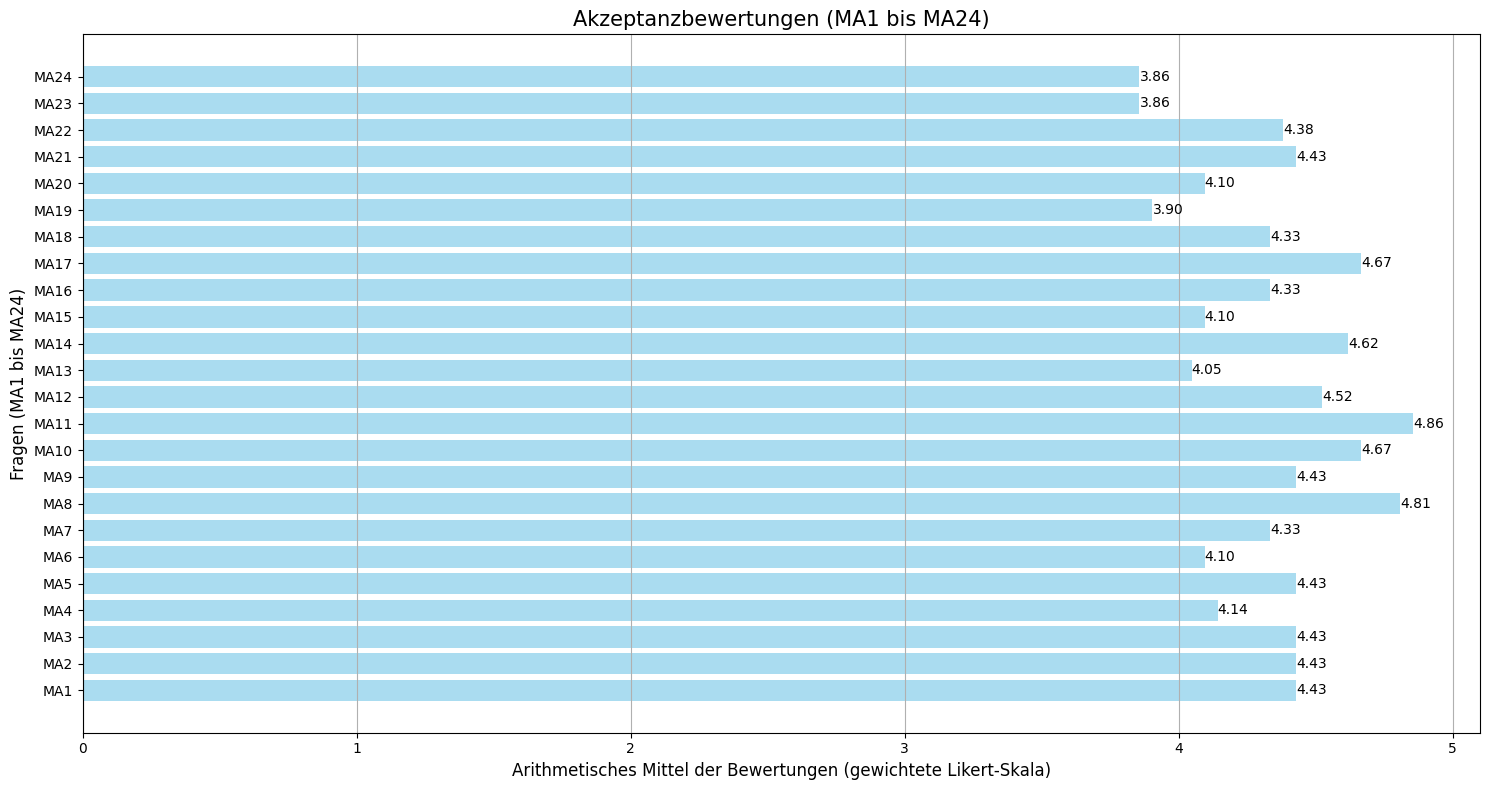

In [83]:
# bar chart
plt.figure(figsize=(15, 8))
bars = plt.barh(questions_filtered, scores_filtered, color="skyblue", alpha=0.7)

# Plot values on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f"{bar.get_width():.2f}", 
             va="center", ha="left", color="black", fontsize=10)

plt.ylabel("Fragen (MA1 bis MA24)", fontsize=12)
plt.xlabel("Arithmetisches Mittel der Bewertungen (gewichtete Likert-Skala)", fontsize=12)
plt.title("Akzeptanzbewertungen (MA1 bis MA24)", fontsize=15)
plt.grid(axis="x")

plt.tight_layout()
today = date.today().strftime("%Y-%m-%d")
plot_name = f"acceptance_plot-{today}"
plt.savefig(f"{plot_name}.pdf", format="pdf")

---
        Plot: Overall distribution box plot
---

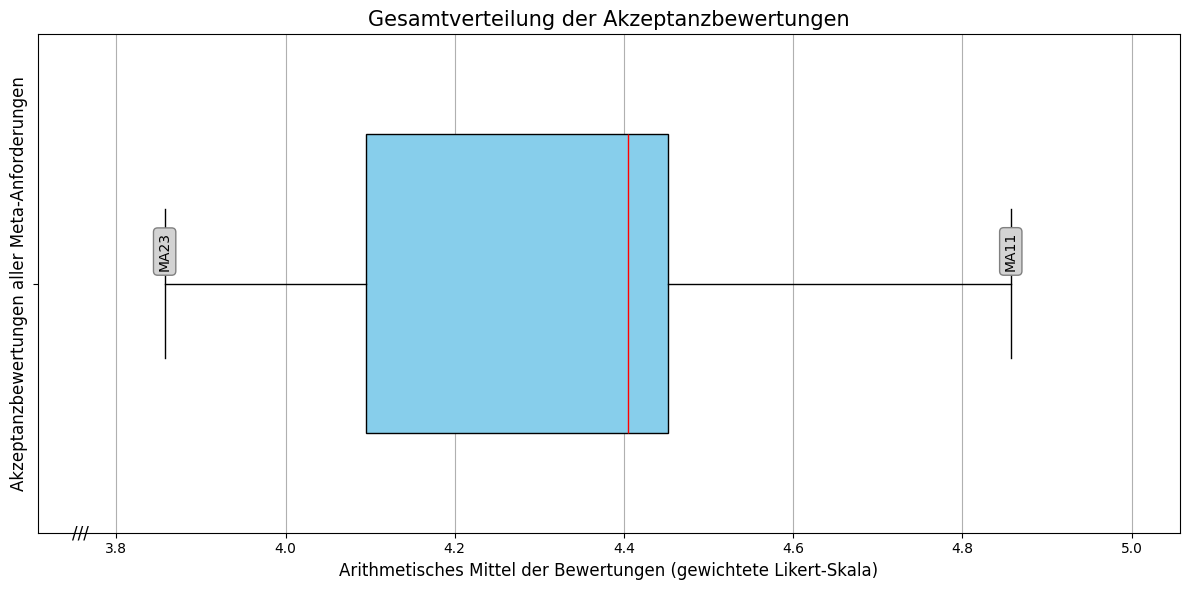

In [109]:
# lowest and highest acceptance scores
lowest_score_question = min(filtered_questions, key=filtered_questions.get)
highest_score_question = max(filtered_questions, key=filtered_questions.get)

# box plot
plt.figure(figsize=(12, 6))
plt.boxplot(scores_filtered, vert=False, widths=0.6, patch_artist=True, 
            medianprops=dict(color="red"), boxprops=dict(facecolor="skyblue"), 
            whiskerprops=dict(color="black"), capprops=dict(color="black"), 
            flierprops=dict(marker="o", color="red", markersize=5))
plt.title("Gesamtverteilung der Akzeptanzbewertungen", fontsize=15)
plt.yticks([1], ["Akzeptanzbewertungen aller Meta-Anforderungen"], rotation=90, va="center", fontsize=12)
plt.xlabel("Arithmetisches Mittel der Bewertungen (gewichtete Likert-Skala)", fontsize=12)
plt.grid(axis="x")
plt.xlim(filtered_questions[lowest_score_question] - 0.15, filtered_questions[highest_score_question] + 0.2)

# plot annotations for the lowest and highest scores
plt.annotate(lowest_score_question, 
  xy=(filtered_questions[lowest_score_question], 1), 
  xytext=(filtered_questions[lowest_score_question], 1.025),
  rotation="vertical",
  horizontalalignment="center", verticalalignment="bottom",
  bbox=dict(facecolor="lightgrey", edgecolor="grey", boxstyle="round"))

plt.annotate(highest_score_question, 
  xy=(filtered_questions[highest_score_question], 1), 
  xytext=(filtered_questions[highest_score_question], 1.025),
  rotation="vertical",
  horizontalalignment="center", verticalalignment="bottom",
  bbox=dict(facecolor="lightgrey", edgecolor="grey", boxstyle="round"))

# custom break in x-axis
plt.text((filtered_questions[lowest_score_question] - 0.1), 0.48, '///', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='black')

plt.tight_layout()
today = date.today().strftime("%Y-%m-%d")
plot_name = f"acceptance_boxplot-{today}"
plt.savefig(f"{plot_name}.pdf", format="pdf")
